# Predicting the product_tier column based on other columns

**Author**: Wrijupan Bhattacharyya

**Description**: This notebook is prepared for a Used Cars analytics project. The data consist of one csv files-
  1. cleaned_data.csv - Contains the cleaned data on used car listings from the used car business (after removal of missing values and outliers)

  **Task**: There is one main task this notebook is accomplishing-

    1. Is it possible to predict the product tier from the information given in the other columns?

Product tier is a categorical target, Hence the problem is treated as a Machine Learning classification with highly imbalanced class labels.

**Metric**: 

1. Average of recall obtained on each class (this is given by the "balanced_accuracy metric").


**Standardization**: A ColumnTransformer object from Scikit-learn is used to apply different scaling logic to the columns

**Pipeline**: A Scikit-learn pipeline object is used for scaling and fitting the models to avoid data leakage

**Hyperparameter tuning**: A grid search using RandomizedSearchCV is used to scan the parameter space of the models and evaluation is performed using 5-fold cross-validation

**Models**: The main challenge here is to deal with the imbalanced classes. The following models have been tried:
  1. Logistic Regression

    A. Normal

    B. With balanced class weights

    C. Undersampling with RandomUnderSampler from imblearn

    D. Oversampling with SMOTE from imblearn

  2. Random Forest

    A. Normal

    B. With balanced class weights

    C. Undersampling with RandomUnderSampler from imblearn

    D. Oversampling with SMOTE from imblearn

  3. XGBoost
  
    A. Undersampling with RandomUnderSampler from imblearn

  4. BalancedBaggingClassifier with gradient-boosted base learners

  

**Contents**: The notebook contains the following sections-
  1. Setting up the environment
2. Loading the cleaned data
3. Feature engineering
4. Standization and normalization
5. Diving the data into train and validation sets
6. Training the models
7. Evaluating the models


  

# 1. Setting up the environment


In [1]:
!pip install imblearn

In [2]:
##########################################################
# Import Python libraries
##########################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##########################################################
# Import Scikit-learn libraries
##########################################################
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVR, SVC
from sklearn.utils import class_weight
from sklearn.utils import resample


##########################################################
# Import XGBoost
##########################################################
import xgboost as xgb

# Imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline_with_sampler
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

### Mount google drive

In [3]:
from google.colab import drive
drive.mount('/gdrive')
# Navigate to the Google drive folder where the data is stored

Mounted at /gdrive


# 2. Importing the data

In [ ]:
data = pd.read_csv("./data/cleaned_data.csv")

In [ ]:
data = data.drop(columns=["Unnamed: 0"])

In [ ]:
data.head()

,product_tier,make_name,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days,ctr,created_month,created_dayofweek,created_day,deleted_year,deleted_month,deleted_dayofweek,deleted_day
0,Basic,Mitsubishi,16750,5,2013,3091.0,123.0,30,0.039793,7,1,24,2018,8,4,24
1,Basic,Mercedes-Benz,35950,4,2015,3283.0,223.0,52,0.067926,8,3,16,2018,7,1,10
2,Basic,Ford,1750,6,2003,1856.0,26.0,101,0.014009,7,4,20,2018,10,0,29
3,Basic,Mercedes-Benz,26500,3,2014,490.0,20.0,12,0.040816,8,1,28,2018,8,3,9
4,Basic,Volkswagen,24890,6,2017,125.0,6.0,2,0.048000,10,5,20,2018,10,0,22


In [ ]:
data.head()

,product_tier,make_name,price,first_zip_digit,first_registration_year,search_views,detail_views,stock_days,ctr,created_month,created_dayofweek,created_day,deleted_year,deleted_month,deleted_dayofweek,deleted_day
0,Basic,Mitsubishi,16750,5,2013,3091.0,123.0,30,0.039793,7,1,24,2018,8,4,24
1,Basic,Mercedes-Benz,35950,4,2015,3283.0,223.0,52,0.067926,8,3,16,2018,7,1,10
2,Basic,Ford,1750,6,2003,1856.0,26.0,101,0.014009,7,4,20,2018,10,0,29
3,Basic,Mercedes-Benz,26500,3,2014,490.0,20.0,12,0.040816,8,1,28,2018,8,3,9
4,Basic,Volkswagen,24890,6,2017,125.0,6.0,2,0.048000,10,5,20,2018,10,0,22


# 3. Feature engineering

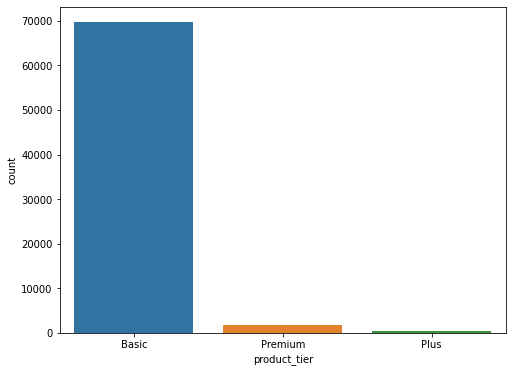

In [ ]:
# Visualizing the target column: product tier
plt. figure(figsize=(8, 6))
sns.countplot(x='product_tier', data=data)

In [ ]:
print(data.product_tier.value_counts())

Basic      69689
Premium     1731
Plus         513
Name: product_tier, dtype: int64


The class labels are highly imbalanced as apparent from the above figure and value counts. Apart from the feature engineering, specific techniques will be applied to fight the bias against imbalanced class labels.

### 3.1 Years since first registration

This is a new feature indicating how long has passed since the last registration of the car listing.

In [ ]:
data['yrs_since_first_reg'] = data['deleted_year'] - data['first_registration_year']

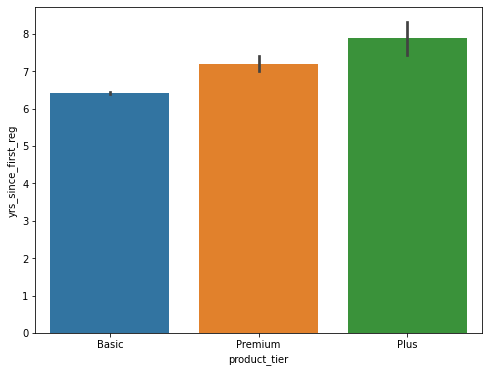

In [ ]:
### yrs_since_first_reg vs product_tier
plt.figure(figsize=(8, 6))

sns.barplot(x='product_tier', y='yrs_since_first_reg', data=data)

### 3.2 Price per click

A new feature is generated by multiplying the price with the click through rate

In [ ]:
data['price_per_click'] = data['price'] * data['ctr']

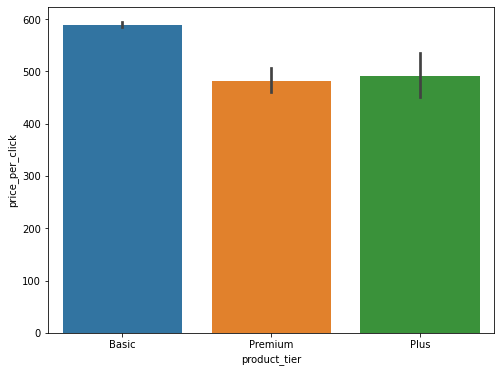

In [ ]:
### yrs_since_first_reg vs product_tier
plt.figure(figsize=(8, 6))

sns.barplot(x='product_tier', y='price_per_click', data=data)

### 3.3 Dropping certain features
Certain features out of which already new features are engineered or those that do not act as the major distinguishing factors for the product_tier are dropped.

In [ ]:
data2 = data.drop(columns=['created_month', 
                              'created_dayofweek', 'created_day', 'deleted_day',
                              'deleted_year', 'deleted_month', 'deleted_dayofweek', 
                              'price', 'ctr'])

In [ ]:
data3 = data2.drop(columns=['first_registration_year'])

### 3.4 Label encoding the product tier column

In [ ]:
### Product tier
le = LabelEncoder()

data3['product_tier'] = le.fit_transform(data3['product_tier'])
data3.head()

,product_tier,make_name,first_zip_digit,search_views,detail_views,stock_days,yrs_since_first_reg,price_per_click
0,0,Mitsubishi,5,3091.0,123.0,30,5,666.531867
1,0,Mercedes-Benz,4,3283.0,223.0,52,3,2441.928115
2,0,Ford,6,1856.0,26.0,101,15,24.515086
3,0,Mercedes-Benz,3,490.0,20.0,12,4,1081.632653
4,0,Volkswagen,6,125.0,6.0,2,1,1194.720000


### 3.5 One-hot encoding the make_name column

In [ ]:
data4 = pd.get_dummies(data3, 
                       columns=['make_name'], 
                       drop_first=True)

In [ ]:
data4.head()

,product_tier,first_zip_digit,search_views,detail_views,stock_days,yrs_since_first_reg,price_per_click,make_name_Aixam,make_name_Alfa Romeo,make_name_Alpina,make_name_Aston Martin,make_name_Audi,make_name_BMW,make_name_Bentley,make_name_Buick,make_name_Cadillac,make_name_Caravans-Wohnm,make_name_Casalini,make_name_Chatenet,make_name_Chevrolet,make_name_Chrysler,make_name_Citroen,make_name_DFSK,make_name_DS Automobiles,make_name_Dacia,make_name_Daewoo,make_name_Daihatsu,make_name_Dodge,make_name_FISKER,make_name_Fiat,make_name_Ford,make_name_GMC,make_name_Grecav,make_name_HUMMER,make_name_Honda,make_name_Hyundai,make_name_Infiniti,make_name_Isuzu,make_name_Iveco,make_name_Jaguar,make_name_Jeep,make_name_KTM,make_name_Kawasaki,make_name_Kia,make_name_Lancia,make_name_Land Rover,make_name_Lexus,make_name_Ligier,make_name_Lincoln,make_name_MAN,make_name_MG,make_name_MINI,make_name_Maserati,make_name_Mazda,make_name_Mercedes-Benz,make_name_Microcar,make_name_Mitsubishi,make_name_Morgan,make_name_Nissan,make_name_Opel,make_name_Others,make_name_Peugeot,make_name_Porsche,make_name_Renault,make_name_Rover,make_name_SEAT,make_name_Saab,make_name_Skoda,make_name_SsangYong,make_name_Subaru,make_name_Suzuki,make_name_Tesla,make_name_Toyota,make_name_Triumph,make_name_Trucks-Lkw,make_name_Volkswagen,make_name_Volvo,make_name_smart
0,0,5,3091.0,123.0,30,5,666.531867,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,4,3283.0,223.0,52,3,2441.928115,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,6,1856.0,26.0,101,15,24.515086,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,3,490.0,20.0,12,4,1081.632653,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,6,125.0,6.0,2,1,1194.720000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


# 4. Dividing the data into training and validation sets

  1. The training set is used to train the model. The training set is validated using 5-fold cross-validation
  
  2. The validation set is not used in the modelling. It is used to independently test the model performance after training

In [ ]:
X = data4.drop(columns=['product_tier'])
y = data4[['product_tier']]

In [ ]:
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y, 
                                                                    test_size=0.2, 
                                                                    random_state=42)

# 5. Normalization of the data

Three types of normalizations are used-

1. RobustScaler: Used for scaling the columns affected by outliers
2. MinMaxScaler: Used to scale columns which do not have a continuous distribution

In order to avoid data leakage, the scalers are-

  1. Fitted to the train data
  2. The obtained statistics are applied to the test data

In [ ]:
# A column transformer object is used to apply different scaling logic
# to the different columns
def feature_transformer(minmax_cols, rob_cols):
    """
    Returns a transformer object
    """
    minmax_scaler = MinMaxScaler()
    rob_scaler = RobustScaler()
    
    ct = ColumnTransformer([('minmax', 
                         minmax_scaler, 
                         minmax_cols
                        ), 
                        ('rob', 
                         rob_scaler, 
                         rob_cols
                        )], 
                       remainder='passthrough')
    return ct

In [ ]:
minmax_cols = ['first_zip_digit', 'yrs_since_first_reg']
rob_cols = ['search_views', 'detail_views', 'stock_days', 'price_per_click']

In [ ]:
preprocessor = feature_transformer(minmax_cols=minmax_cols,
                                   rob_cols=rob_cols,
                                   )

# 6. Training the models

**Dealing with highly imbalanced classes**: As noted above the dataset contains highly imbalanced classes. To fight the bias against high class imbalance the following strategies are applied -

1. Changing the algorithms using the "class_weight=balanced" parameter to create a balanced class while training.
2. Over-sampling the minority class using SMOTE from Imblearn
3. Randomly Undersampling the majority class using the RandomUndersampling from Imblearn
4. Trying out Balanced Bagging Classifier with a gradient boosting base learner

  

**Baseline model**: DummyClassifier

**Metric**: Average Recall for all classes is used as the evaulation metric for both K-fold cross-validation and also for model evaluation on the test data

### 6.1 Dummy Classifier

In [ ]:
index = []
scores = {"Averaged Recall": []}

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")

scoring = ["balanced_accuracy"]

index += ["Dummy classifier"]
cv_result = cross_validate(dummy_clf, X_train_cls, y_train_cls, scoring=scoring)

scores["Averaged Recall"].append(cv_result["test_balanced_accuracy"].mean())

df_scores = pd.DataFrame(scores, index=index)
df_scores.head()

,Averaged Recall
Dummy classifier,0.333333


### 6.2 Logistic Regression

In [ ]:
# Define  estimator
logreg = LogisticRegression(random_state=42, multi_class='ovr', solver='lbfgs')

# Define pipeline
steps_logreg = [('scaler', preprocessor), ('logreg', logreg)]

pipe_logreg = Pipeline(steps_logreg)

# Implement Grid Search
params_logreg = {'logreg__C' : [1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10.]
              }

rs_logreg = RandomizedSearchCV(pipe_logreg, 
                                param_distributions=params_logreg, 
                                n_iter=6, 
                                scoring='balanced_accuracy', 
                                n_jobs=-1, 
                                cv=5, 
                                random_state=42, 
                                verbose=2)

# Run grid search and cross-validation
rs_logreg.fit(X_train_cls, y_train_cls)

# Fill the score DF
index += ["LogisticRegression"]

scores['Averaged Recall'].append(rs_logreg.best_score_)

df_scores = pd.DataFrame(scores, index=index)
df_scores.head()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   45.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logi

,Averaged Recall
Dummy classifier,0.333333
LogisticRegression,0.408502


### 6.3 Random Forest

In [ ]:
# Define  estimator
rf_reg = RandomForestClassifier(random_state=42)

# Define Pipeline
steps_rf_reg = [('scaler', preprocessor), ('rf_reg', rf_reg)]

pipe_rf_reg = Pipeline(steps_rf_reg)

# Implement Grid Search
params_rf_reg = {'rf_reg__n_estimators' : [50, 100, 150, 200,], 
                  'rf_reg__max_depth': np.arange(2, 6),  
                  'rf_reg__min_samples_leaf': np.arange(3, 7),
                  'rf_reg__max_samples': [0.5, 0.6, 0.7, 0.8]
                  }

rs_rf_reg = RandomizedSearchCV(pipe_rf_reg, 
                                param_distributions=params_rf_reg, 
                                n_iter=12, 
                                scoring='balanced_accuracy', 
                                n_jobs=-1, 
                                cv=5, 
                                random_state=42, 
                                verbose=2)

# Run grid search and cross-validation
rs_rf_reg.fit(X_train_cls, y_train_cls)

# Fill the score DF
index += ["RandomForest"]

scores['Averaged Recall'].append(rs_rf_reg.best_score_)

df_scores = pd.DataFrame(scores, index=index)
df_scores.head(30)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


,Averaged Recall
Dummy classifier,0.333333
LogisticRegression,0.408502
RandomForest,0.333333


### 6.4 Logistic Regression with balanced class weights

class_weight="balanced" is set so that the algorithm can adjust the classes by upsampling the minorities to obtain a balanced training data.

In [ ]:
# Define  estimator
logreg_bal = LogisticRegression(random_state=42, multi_class='ovr', solver='lbfgs', class_weight='balanced')

# Define pipeline
steps_logreg_bal = [('scaler', preprocessor), ('logreg_bal', logreg_bal)]

pipe_logreg_bal = Pipeline(steps_logreg_bal)

# Implement Grid Search
params_logreg_bal = {'logreg_bal__C' : [1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10.]
                     }

rs_logreg_bal = RandomizedSearchCV(pipe_logreg_bal, 
                                    param_distributions=params_logreg_bal, 
                                    n_iter=6, 
                                    scoring='balanced_accuracy', 
                                    n_jobs=-1, 
                                    cv=5, 
                                    random_state=42, 
                                    verbose=2)

# Run grid search and cross-validation
rs_logreg_bal.fit(X_train_cls, y_train_cls)

# Fill the score DF
index += ["LogisticRegression with balanced class weights"]

scores['Averaged Recall'].append(rs_logreg_bal.best_score_)

df_scores = pd.DataFrame(scores, index=index)
df_scores.head()

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logi

,Averaged Recall
Dummy classifier,0.333333
LogisticRegression,0.408502
RandomForest,0.333333
LogisticRegression with balanced class weights,0.623564


### 6.5 Random Forest with balanced class weights
class_weight="balanced" is set so that the algorithm can adjust the classes by upsampling the minorities to obtain a balanced training data.

In [ ]:
# Define  estimator
rf_reg_bal = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define Pipeline
steps_rf_reg_bal = [('scaler', preprocessor), ('rf_reg_bal', rf_reg_bal)]

pipe_rf_reg_bal = Pipeline(steps_rf_reg_bal)

# Implement Grid Search
params_rf_reg_bal = {'rf_reg_bal__n_estimators' : [50, 100, 150, 200,], 
                      'rf_reg_bal__max_depth': np.arange(2, 6),  
                      'rf_reg_bal__min_samples_leaf': np.arange(3, 7),
                      'rf_reg_bal__max_samples': [0.5, 0.6, 0.7, 0.8]
                      }

rs_rf_reg_bal = RandomizedSearchCV(pipe_rf_reg_bal, 
                                    param_distributions=params_rf_reg_bal, 
                                    n_iter=12, 
                                    scoring='balanced_accuracy', 
                                    n_jobs=-1, 
                                    cv=5, 
                                    random_state=42, 
                                    verbose=2)

# Run grid search and cross-validation
rs_rf_reg_bal.fit(X_train_cls, y_train_cls)

# Fill the score DF
index += ["RandomForest with balanced class weights"]

scores['Averaged Recall'].append(rs_rf_reg_bal.best_score_)

df_scores = pd.DataFrame(scores, index=index)
df_scores.head(30)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.8min finished
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


,Averaged Recall
Dummy classifier,0.333333
LogisticRegression,0.408502
RandomForest,0.333333
LogisticRegression with balanced class weights,0.623564
RandomForest with balanced class weights,0.599854


### 6.6 Oversampling + Logistic Regression

SMOTE: Used for oversampling the minority classes

In [ ]:
# Define  estimator
logreg_rus = LogisticRegression(random_state=42, multi_class='ovr', solver='lbfgs')

# Define pipeline
steps_logreg_rus = [('scaler', preprocessor), ('over', SMOTE(random_state=42)), ('logreg_rus', logreg_rus)]

pipe_logreg_rus = Pipeline_with_sampler(steps_logreg_rus)

# Implement Grid Search
params_logreg_rus = {'logreg_rus__C' : [1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10.]
                     }

rs_logreg_rus = RandomizedSearchCV(pipe_logreg_rus, 
                                    param_distributions=params_logreg_rus, 
                                    n_iter=6, 
                                    scoring='balanced_accuracy', 
                                    n_jobs=-1, 
                                    cv=5, 
                                    random_state=42, 
                                    verbose=2)

# Run grid search and cross-validation
rs_logreg_rus.fit(X_train_cls, y_train_cls)

# Fill the score DF
index += ["LogisticRegression+Oversampling"]

scores['Averaged Recall'].append(rs_logreg_rus.best_score_)

df_scores = pd.DataFrame(scores, index=index)
df_scores.head(50)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.6min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceW

,Averaged Recall
Dummy classifier,0.333333
LogisticRegression,0.408502
RandomForest,0.333333
LogisticRegression with balanced class weights,0.623564
RandomForest with balanced class weights,0.599854
LogisticRegression+Oversampling,0.630164


### 6.7 Oversampling + Random Forest
SMOTE: Used for over-sampling the minority class

In [ ]:
# Define  estimator
rf_reg_rus = RandomForestClassifier(random_state=42)

# Define Pipeline
steps_rf_reg_rus = [('scaler', preprocessor), ('over', SMOTE(random_state=42)), ('rf_reg_rus', rf_reg_rus)]

pipe_rf_reg_rus = Pipeline_with_sampler(steps_rf_reg_rus)

# Implement Grid Search
params_rf_reg_rus = {'rf_reg_rus__n_estimators' : [100, 150, 200,], 
                      'rf_reg_rus__max_depth': np.arange(2, 6),  
                      'rf_reg_rus__min_samples_leaf': np.arange(3, 6),
                      'rf_reg_rus__max_samples': [0.5, 0.6, 0.7, 0.8]
                      }

rs_rf_reg_rus = RandomizedSearchCV(pipe_rf_reg_rus, 
                                    param_distributions=params_rf_reg_rus, 
                                    n_iter=6, 
                                    scoring='balanced_accuracy', 
                                    n_jobs=-1, 
                                    cv=5, 
                                    random_state=42, 
                                    verbose=2)

# Run grid search and cross-validation
rs_rf_reg_rus.fit(X_train_cls, y_train_cls)

# Fill the score DF
index += ["RandomForest+Oversampling"]

scores['Averaged Recall'].append(rs_rf_reg_rus.best_score_)

df_scores = pd.DataFrame(scores, index=index)
df_scores.head(30)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


,Averaged Recall
Dummy classifier,0.333333
LogisticRegression,0.408502
RandomForest,0.333333
LogisticRegression with balanced class weights,0.623564
RandomForest with balanced class weights,0.599854
LogisticRegression+Oversampling,0.630164
RandomForest+Oversampling,0.582733


### 6.8 Undersampling + Logistic Regression

Oversampling did not help much.

Let us try randomly undersampling the majority class using RandomUnderSampler from imblearn.

In [ ]:
# Define  estimator
logreg_rus = LogisticRegression(random_state=42, multi_class='ovr', solver='lbfgs')

# Define pipeline
steps_logreg_rus = [('scaler', preprocessor), ('under', RandomUnderSampler(random_state=42)), ('logreg_rus', logreg_rus)]

pipe_logreg_rus = Pipeline_with_sampler(steps_logreg_rus)

# Implement Grid Search
params_logreg_rus = {'logreg_rus__C' : [1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10.]
                     }

rs_logreg_rus = RandomizedSearchCV(pipe_logreg_rus, 
                                    param_distributions=params_logreg_rus, 
                                    n_iter=6, 
                                    scoring='balanced_accuracy', 
                                    n_jobs=-1, 
                                    cv=5, 
                                    random_state=42, 
                                    verbose=2)

# Run grid search and cross-validation
rs_logreg_rus.fit(X_train_cls, y_train_cls)

# Fill the score DF
index += ["LogisticRegression+Undersampling"]

scores['Averaged Recall'].append(rs_logreg_rus.best_score_)

df_scores = pd.DataFrame(scores, index=index)
df_scores.head(50)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Averaged Recall
Dummy classifier,0.333333
LogisticRegression,0.408502
RandomForest,0.333333
LogisticRegression with balanced class weights,0.623564
RandomForest with balanced class weights,0.599854
LogisticRegression+Oversampling,0.630164
RandomForest+Oversampling,0.582733
LogisticRegression+Undersampling,0.618615


### Undersampling + Random Forest

Let us try to undersample the majority classes using RandomUnderSampler from imblearn and combining it with Random Forest.

In [ ]:
# Define  estimator
rf_reg_rus = RandomForestClassifier(random_state=42)

# Define Pipeline
steps_rf_reg_rus = [('scaler', preprocessor), ('under', RandomUnderSampler(random_state=42)), ('rf_reg_rus', rf_reg_rus)]

pipe_rf_reg_rus = Pipeline_with_sampler(steps_rf_reg_rus)

# Implement Grid Search
params_rf_reg_rus = {'rf_reg_rus__n_estimators' : [50, 100, 150, 200,], 
                      'rf_reg_rus__max_depth': np.arange(2, 6),  
                      'rf_reg_rus__min_samples_leaf': np.arange(3, 7),
                      'rf_reg_rus__max_samples': [0.5, 0.6, 0.7, 0.8]
                      }

rs_rf_reg_rus = RandomizedSearchCV(pipe_rf_reg_rus, 
                                    param_distributions=params_rf_reg_rus, 
                                    n_iter=12, 
                                    scoring='balanced_accuracy', 
                                    n_jobs=-1, 
                                    cv=5, 
                                    random_state=42, 
                                    verbose=2)

# Run grid search and cross-validation
rs_rf_reg_rus.fit(X_train_cls, y_train_cls)

# Fill the score DF
index += ["RandomForest+Undersampling"]

scores['Averaged Recall'].append(rs_rf_reg_rus.best_score_)

df_scores = pd.DataFrame(scores, index=index)
df_scores.head(30)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   21.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/imblearn/pipeline.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)


,Averaged Recall
Dummy classifier,0.333333
LogisticRegression,0.408502
RandomForest,0.333333
LogisticRegression with balanced class weights,0.623564
RandomForest with balanced class weights,0.599854
LogisticRegression+Oversampling,0.630164
RandomForest+Oversampling,0.582733
LogisticRegression+Undersampling,0.618615
RandomForest+Undersampling,0.592551


### Undersampling + XGBoost

Let us now use XGBoost along with undersampling to check whether the performance improves.

In [ ]:
# Define  estimator
xgb_reg_rus = xgb.XGBClassifier(random_state=42, 
                                objective='multi:softmax',
                                booster='gbtree',
                              )

# Define pipeline
steps_xgb_reg_rus = [('scaler', preprocessor), ('under', RandomUnderSampler(random_state=42)), ('xgb_reg_rus', xgb_reg_rus)]

pipe_xgb_reg_rus = Pipeline_with_sampler(steps_xgb_reg_rus)

# Implement Grid Search
params_xgb_reg_rus = {'xgb_reg_rus__n_estimators' : [50, 100, 150, 200,], 
                      'xgb_reg_rus__max_depth': np.arange(2, 6),  
                      'xgb_reg_rus__min_samples_leaf': np.arange(3, 7),
                      'xgb_reg_rus__learning_rate' : [0.001, 0.01, 0.1],
                      'xgb_reg_rus__gamma' : [0.01, 0.1], 
                      'xgb_reg_rus__reg_alpha' : np.logspace(-3, 1.4, 6),
                      'xgb_reg_rus__reg_lambda' : np.logspace(-3, 1.4, 6),
                      }

rs_xgb_reg_rus = RandomizedSearchCV(pipe_xgb_reg_rus, 
                                    param_distributions=params_xgb_reg_rus, 
                                    n_iter=15, 
                                    scoring='balanced_accuracy', 
                                    n_jobs=-1, 
                                    cv=5, 
                                    random_state=42, 
                                    verbose=2)

# Run grid search and cross-validation
rs_xgb_reg_rus.fit(X_train_cls, y_train_cls)

# Fill the score DF
index += ["XGBoost+Undersampling"]

scores['Averaged Recall'].append(rs_xgb_reg_rus.best_score_)

df_scores = pd.DataFrame(scores, index=index)
df_scores.head()

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.1min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Averaged Recall
Dummy classifier,0.333333
LogisticRegression,0.408502
RandomForest,0.333333
LogisticRegression with balanced class weights,0.623564
RandomForest with balanced class weights,0.599854


In [ ]:
df_scores.head(30)

,Averaged Recall
Dummy classifier,0.333333
LogisticRegression,0.408502
RandomForest,0.333333
LogisticRegression with balanced class weights,0.623564
RandomForest with balanced class weights,0.599854
LogisticRegression+Oversampling,0.630164
RandomForest+Oversampling,0.582733
LogisticRegression+Undersampling,0.618615
RandomForest+Undersampling,0.592551
XGBoost+Undersampling,0.677469


XGBoost + Undersampling seems to have improved the performance a lot compared to the previous models. 

### Balanced Bagging Classifier with gradient-boosted base learners

Undersampling seems to improve the performance in tree-based models. Instead of undersampling once the entire dataset, next I will try a BalancedBaggingClassifier that will undersample the original dataset before to take a bootstrap sample. The base learner used in this case is a gradient-boosted tree-based model.

In [ ]:
#Define estimator
bag_clf = BalancedBaggingClassifier(
                                    base_estimator=HistGradientBoostingClassifier(random_state=42, 
                                                                                  max_depth=5, 
                                                                                  l2_regularization=0.01),
                                    random_state=42,
                                    n_jobs=-1,
                                    n_estimators=60,
                                    )

# Define Pipeline
steps_bag_clf = [('scaler', preprocessor), ('bag_clf', bag_clf)]

pipe_bag_clf = Pipeline(steps_bag_clf)

index += ["Balanced bag of histogram gradient boosting"]

cv_result = cross_validate(pipe_bag_clf, 
                           X_train_cls, 
                           y_train_cls, 
                           scoring=["balanced_accuracy"], 
                           cv=5)

final_cval_score = np.around(cv_result["test_balanced_accuracy"].mean(), 2)
scores["Averaged Recall"].append(final_cval_score)

df_scores = pd.DataFrame(scores, index=index)
df_scores.head(30)

#print(cv_result["test_balanced_accuracy"].mean())

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

,Averaged Recall
Dummy classifier,0.333333
LogisticRegression,0.408502
RandomForest,0.333333
LogisticRegression with balanced class weights,0.623564
RandomForest with balanced class weights,0.599854
LogisticRegression+Oversampling,0.630164
RandomForest+Oversampling,0.582733
LogisticRegression+Undersampling,0.618615
RandomForest+Undersampling,0.592551
XGBoost+Undersampling,0.677469


# 7. Model evaluation

### Balanced bag of histogram boosting

In [ ]:
bag_clf_train = pipe_bag_clf.fit(X_train_cls, y_train_cls)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_pred_bag = pipe_bag_clf.predict(X_test_cls)

bal_acc_bag = balanced_accuracy_score(y_test_cls, y_pred_bag)

### XGBoost + Undersampling

In [ ]:
y_pred_xgb_rus = rs_xgb_reg_rus.predict(X_test_cls)

bal_acc_xgb_rus = balanced_accuracy_score(y_test_cls, y_pred_xgb_rus)

### RandomForest + Undersampling

In [ ]:
y_pred_rf_rus = rs_rf_reg_rus.predict(X_test_cls)

bal_acc_rf_rus = balanced_accuracy_score(y_test_cls, y_pred_rf_rus)

### Logistic Regression + Undersampling

In [ ]:
y_pred_logreg_rus = rs_logreg_rus.predict(X_test_cls)

bal_acc_logreg_rus = balanced_accuracy_score(y_test_cls, y_pred_logreg_rus)

### Dummy clf

In [ ]:
dummy_clf.fit(X_train_cls, y_train_cls)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [ ]:
y_pred_dummy_clf = dummy_clf.predict(X_test_cls)

bal_acc_dummy_clf = balanced_accuracy_score(y_test_cls, y_pred_dummy_clf)

### Summary of the test set predictions

In [ ]:
df_recall = pd.DataFrame()

df_recall['Model'] = ['Dummy Classifier', 
                    'Logistic Regression+Undersampling', 
                    'RandomForest+Undersampling', 
                    'XGBoost+Undersampling', 
                    'Balanced_bag_of_hist_boosting']

df_recall['Averaged Recall'] = [bal_acc_dummy_clf, 
                                bal_acc_logreg_rus, 
                                bal_acc_rf_rus, 
                                bal_acc_xgb_rus, 
                                bal_acc_bag]


df_recall.head()

,Model,Averaged Recall
0,Dummy Classifier,0.333333
1,Logistic Regression+Undersampling,0.637221
2,RandomForest+Undersampling,0.610754
3,XGBoost+Undersampling,0.689607
4,Balanced_bag_of_hist_boosting,0.703528
